In [131]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
# Load data
data_A = np.genfromtxt('data/DetectorA.csv', delimiter=',', skip_header=1).T
data_B = np.genfromtxt('data/DetectorB.csv', delimiter=',', skip_header=1).T
data_C = np.genfromtxt('data/DetectorC.csv', delimiter=',', skip_header=1).T
data_Target = np.genfromtxt('data/DetectorTarget.csv', delimiter=',', skip_header=1).T

In [133]:
# Score
score_A = data_A[1]
score_B = data_B[1]
score_C = data_C[1]
score_Target = data_Target[1]

# Energy
energy_A = data_A[2]
energy_B = data_B[2]
energy_C = data_C[2]
energy_Target = data_Target[2]


In [134]:
# Set limits
energy_upper_limit = 3500
energy_lower_limit = 1000

score_A = score_A[energy_A < energy_upper_limit]
score_B = score_B[energy_B < energy_upper_limit]
score_C = score_C[energy_C < energy_upper_limit]
score_Target = score_Target[energy_Target < energy_upper_limit]

energy_A = energy_A[energy_A < energy_upper_limit]
energy_B = energy_B[energy_B < energy_upper_limit]
energy_C = energy_C[energy_C < energy_upper_limit]
energy_Target = energy_Target[energy_Target < energy_upper_limit]

(1000.0, 3309.63105)

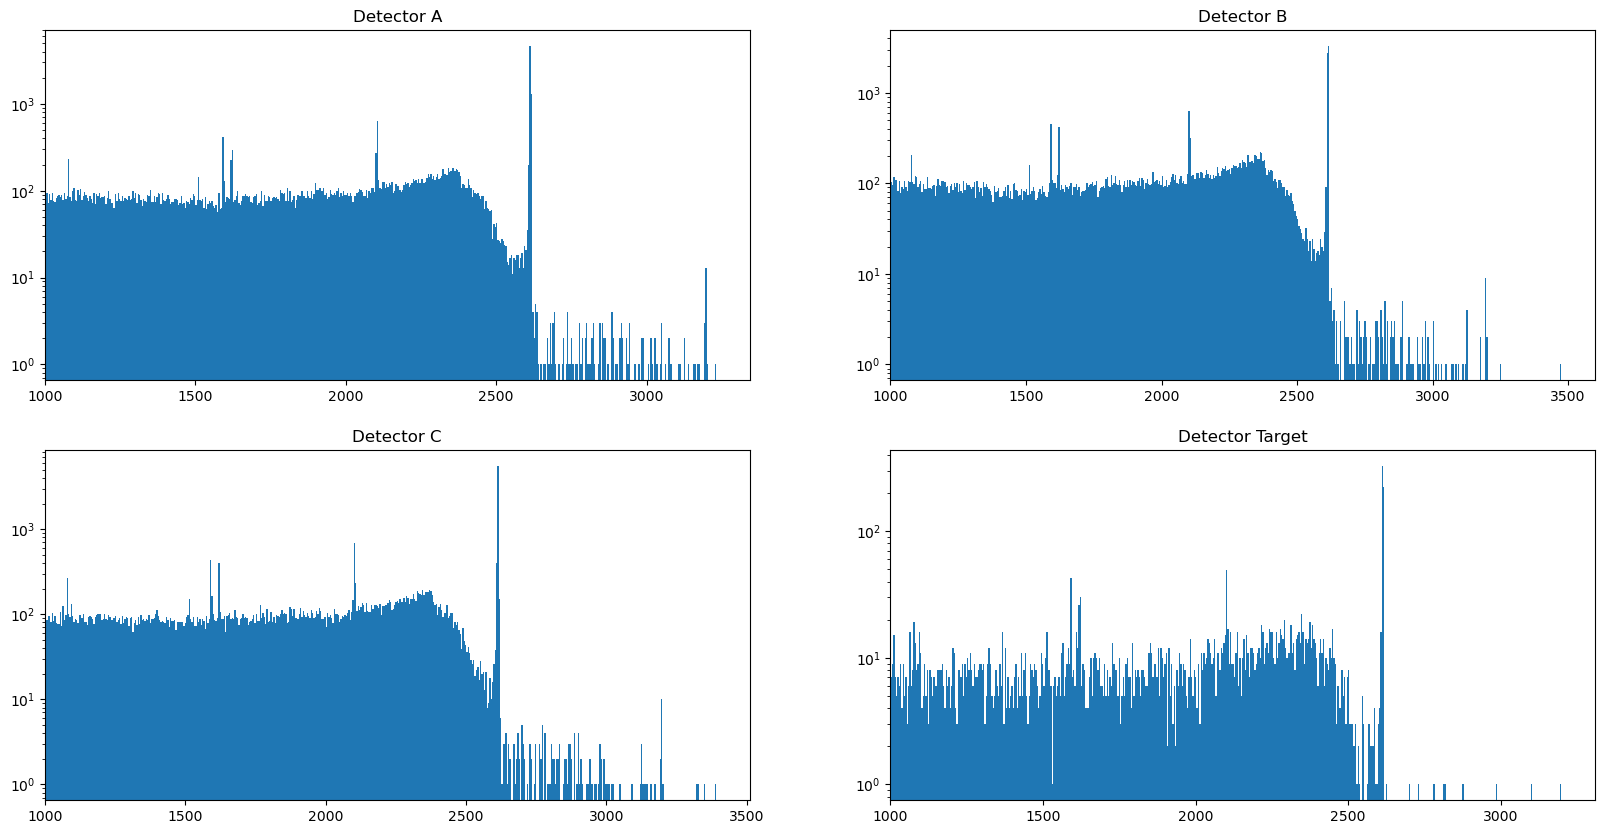

In [135]:
# Create histograms
n_bins = 500
hist_A, bins_A = np.histogram(energy_A, bins=n_bins)
hist_B, bins_B = np.histogram(energy_B, bins=n_bins)
hist_C, bins_C = np.histogram(energy_C, bins=n_bins)
hist_Target, bins_Target = np.histogram(energy_Target, bins=n_bins)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(1000)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(1000)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(1000)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(1000)


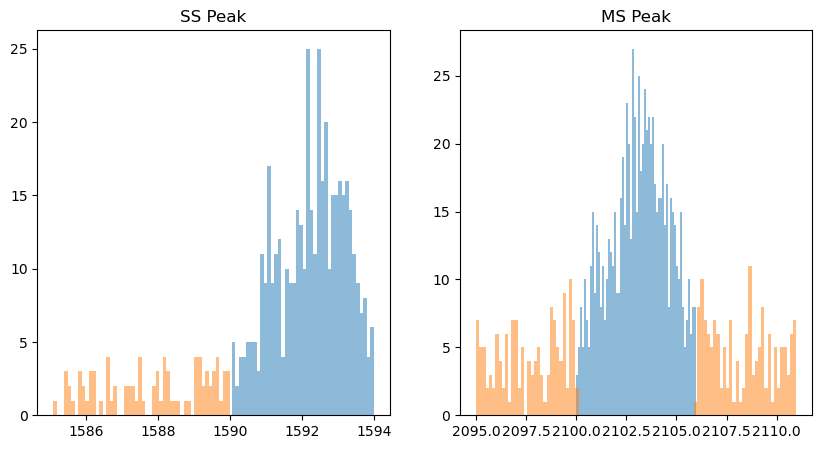

In [136]:
# Range of SS peak
ss_lower_limit = 1590
ss_upper_limit = 1594

# Range of MS peak
ms_lower_limit = 2100
ms_upper_limit = 2106

# Range of SS baseline
ss_baseline_lower_limit = 1585

# Range of MS baseline
ms_baseline_lower_limit = 2095
ms_baseline_upper_limit = 2111

ss = energy_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms = energy_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline = energy_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline = energy_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

bin_width = 0.1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title('SS Peak')
_ = axes[0].hist(ss, bins=int((ss_upper_limit-ss_lower_limit)/bin_width), alpha=0.5, label='Peak')
_ = axes[0].hist(ss_baseline, bins=int((ss_lower_limit-ss_baseline_lower_limit)/bin_width), alpha=0.5, label='Baseline')

axes[1].set_title('MS Peak')
_ = axes[1].hist(ms, bins=int((ms_upper_limit-ms_lower_limit)/bin_width), alpha=0.5, label='Peak')
_ = axes[1].hist(ms_baseline, bins=int((ms_lower_limit-ms_baseline_lower_limit + ms_baseline_upper_limit - ms_upper_limit)/bin_width), alpha=0.5, label='Baseline')

In [137]:
ss_score = score_A[(energy_A > ss_lower_limit) & (energy_A < ss_upper_limit)]
ms_score = score_B[(energy_B > ms_lower_limit) & (energy_B < ms_upper_limit)]

ss_baseline_score = score_A[(energy_A > ss_baseline_lower_limit) & (energy_A < ss_lower_limit)]
ms_baseline_score = score_B[((energy_B > ms_baseline_lower_limit) & (energy_B < ms_lower_limit)) | ((energy_B > ms_upper_limit) & (energy_B < ms_baseline_upper_limit))]

Ns = ss.size
Bs = ss_baseline.size
Nb = ms.size
Bb = ms_baseline.size

# Return TPR, FPR
def metrics(threshold, tau_ss=1, tau_ms=0.5):
    Ntp = np.sum(ss_score > threshold)
    Bss = np.sum(ss_baseline_score > threshold)
    Nfp = np.sum(ms_score > threshold)
    Bms = np.sum(ms_baseline_score > threshold)
    return (Ntp - tau_ss * Bss) / (Ns - tau_ss * Bs), (Nfp - tau_ms * Bms) / (Nb - tau_ms * Bb)

# Try n thresholds
def roc(n=200):
    return np.array([metrics(t) for t in np.linspace(0, 1, n)])

# Plot ROC curve
def plot_roc(threshold):
    roc_curve = roc()
    selected = metrics(threshold)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(roc_curve[:, 1], roc_curve[:, 0], label='ROC curve')
    ax.plot(selected[1], selected[0], 'ro', label='Selected threshold')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    print(f'Selected threshold: {threshold:.3f}')
    print(f'True positive rate: {selected[0]:.2f}')
    print(f'False positive rate: {selected[1]:.2f}')
    plt.legend()

In [138]:
import ipywidgets as widgets

widgets.interact(plot_roc, 
         threshold=widgets.FloatSlider(min=0, max=1, step=0.005, value=0.5, layout=widgets.Layout(width='50%')))

interactive(children=(FloatSlider(value=0.5, description='threshold', layout=Layout(width='50%'), max=1.0, ste…

<function __main__.plot_roc(threshold)>

In [139]:
# Final selection
selected_threshold = 0.085

selected_energy_A = energy_A[score_A > selected_threshold]
selected_energy_B = energy_B[score_B > selected_threshold]
selected_energy_C = energy_C[score_C > selected_threshold]
selected_energy_Target = energy_Target[score_Target > selected_threshold]

selected_hist_A, selected_bins_A = np.histogram(selected_energy_A, bins=n_bins)
selected_hist_B, selected_bins_B = np.histogram(selected_energy_B, bins=n_bins)
selected_hist_C, selected_bins_C = np.histogram(selected_energy_C, bins=n_bins)
selected_hist_Target, selected_bins_Target = np.histogram(selected_energy_Target, bins=n_bins)

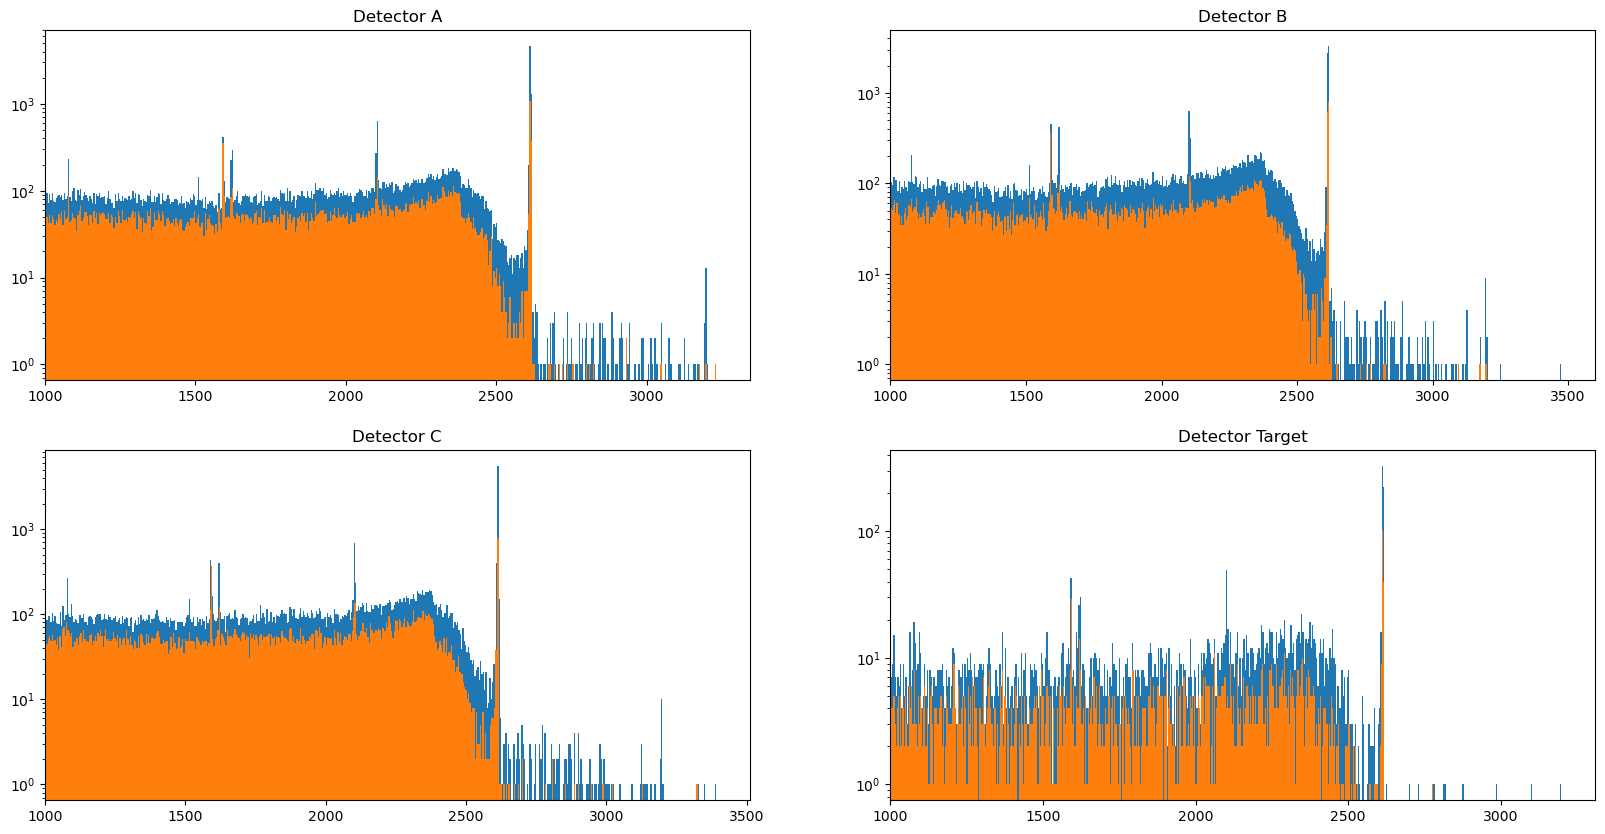

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(hist_A, bins_A, label='Detector A', fill=True)
axes[0, 0].stairs(selected_hist_A, selected_bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(1000)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(hist_B, bins_B, label='Detector B', fill=True)
axes[0, 1].stairs(selected_hist_B, selected_bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(1000)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(hist_C, bins_C, label='Detector C', fill=True)
axes[1, 0].stairs(selected_hist_C, selected_bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(1000)

axes[1, 1].set_title('Detector Target')
axes[1, 1].stairs(hist_Target, bins_Target, label='Detector Target', fill=True)
axes[1, 1].stairs(selected_hist_Target, selected_bins_Target, label='Detector Target', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(1000)

plt.show()


In [141]:
# Normalize histograms to get PDFs
pdf_A = selected_hist_A / np.sum(selected_hist_A)
pdf_B = selected_hist_B / np.sum(selected_hist_B)
pdf_C = selected_hist_C / np.sum(selected_hist_C)

In [142]:
# Gaussian function
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Generate NLDBD PDF
mu = 2039
sigma = 1
bins_N = bins_A
pdf_N = gaussian((bins_N[:-1] + bins_N[1:]) / 2, mu, sigma)

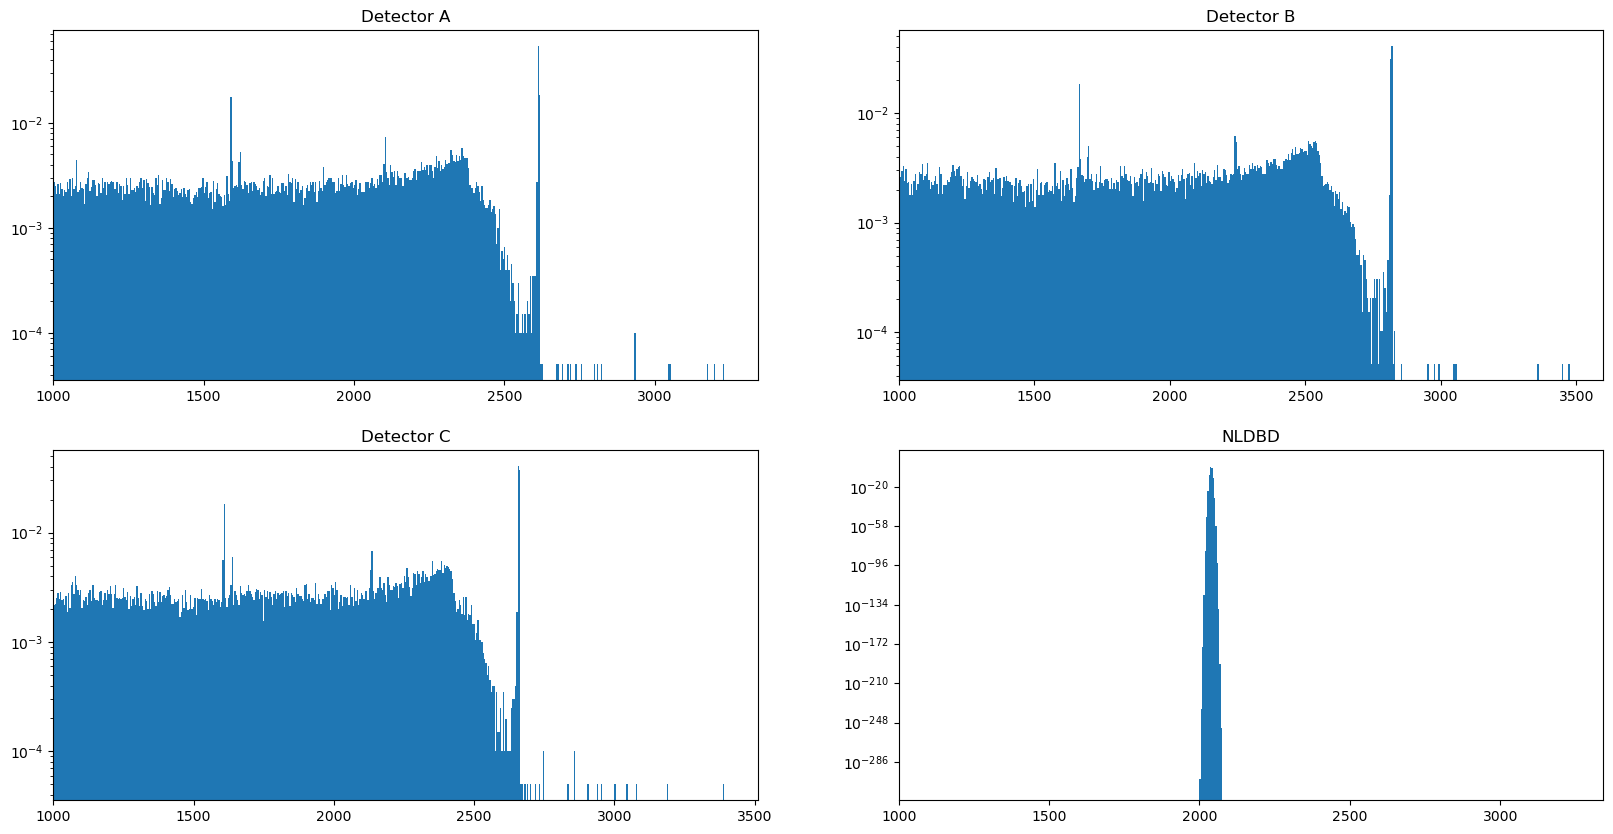

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].set_title('Detector A')
axes[0, 0].stairs(pdf_A, bins_A, label='Detector A', fill=True)
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlim(1000)

axes[0, 1].set_title('Detector B')
axes[0, 1].stairs(pdf_B, bins_B, label='Detector B', fill=True)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(1000)

axes[1, 0].set_title('Detector C')
axes[1, 0].stairs(pdf_C, bins_C, label='Detector C', fill=True)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(1000)

axes[1, 1].set_title('NLDBD')
axes[1, 1].stairs(pdf_N, bins_N, label='NLDBD', fill=True)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(1000)

plt.show()